# Parameterize proxy error in temperature

## Imports and general definitions

Next to the imports necessary, this includes definitions for correcting the AIC and related parameters from the paper. For the mathematical descriptions and derivation, see the paper and the supplementary information.

In [6]:
import numpy as np
import pandas as pd
import os
from urllib import request

import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', size=11, family='serif')

import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.transforms as mtransforms

from PIL import Image

colors = ['#5BC0EB', '#FDE74C', '#9BC53D', '#E55934', '#FA7921']

def correct_beta(beta_est, sigma_x, sigma_eta): 
    return beta_est * (1 + sigma_eta**2 / sigma_x**2)

def correct_sigma(beta_est, sigma_x, sigma_eta, sigma_eps_est):
    beta = correct_beta(beta_est, sigma_x, sigma_eta)
    return sigma_eps_est**2 - (beta**2*sigma_x**2*sigma_eta**2) / (sigma_x**2 + sigma_eta**2)

def correct_loglik(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est):
    return -sample_size / 2 * np.log(2 * np.pi * correct_sigma(beta_est, sigma_x, sigma_eta, sigma_eps_est)) - sample_size / 2

def correct_aic(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est, k=1):
    sigma_x = np.sqrt(sigma_x**2 - sigma_eps_est**2)
    return 2 * k - 2 * correct_loglik(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est)

# Create the folder where all the plots go in case it doesn't exist.
if not os.path.exists('plots'):
    os.makedirs('plots')

In [7]:
if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('data/produkt_klima_tag_18980301_20211231_01757.txt'):
    data_request = request.urlopen('https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/produkt_klima_tag_18980301_20211231_01757.txt')
    with open('data/produkt_klima_tag_18980301_20211231_01757.txt', 'wb') as out:
        out.write(data_request.data)

## Data preprocessing

Reading and formatting the data from the weather station (air and ground temperature) as well as phenology data.
We are here using the mean air temperature in 2m height, filtering out for non-available data.
Ground temperature is also mean temperature from 5cm depth and also filtered for non-available data.

Then the mean temperature of each month is calculated and the data frames are merged together.
For the phenology data, we chose the temperature of march as a predictor, as the flowering dates of wood anemone are typically in april.

In [4]:
data = pd.read_csv('produkt_klima_tag_18980301_20211231_01757.txt', delimiter=';')
data.MESS_DATUM = pd.to_datetime(data.MESS_DATUM, format=r'%Y%m%d')
data = data[data['TMK'] != -999]
data['year'] = data.MESS_DATUM.dt.year
data['month'] = data.MESS_DATUM.dt.month


data_earth = pd.read_csv('produkt_erdbo_tag_19780101_20211231_01757.txt', delimiter=';')
data_earth.MESS_DATUM = pd.to_datetime(data_earth.MESS_DATUM, format=r'%Y%m%d')
data = data.merge(data_earth, on=['STATIONS_ID', 'MESS_DATUM'])

data = data[data['V_TE005M'] != -999]

TMK_monthly = data.groupby(['year', 'month'])['TMK'].aggregate(lambda x: None if len(x) < 28 else x.mean()).dropna().reset_index()
TEK_monthly = data.groupby(['year', 'month'])['V_TE005M'].aggregate(lambda x: None if len(x) < 28 else x.mean()).dropna().reset_index()

monthly = TMK_monthly.merge(TEK_monthly, on=['year', 'month'])

station_id = 1757
phen_data = pd.read_csv('PH_Jahresmelder_Wildwachsende_Pflanze_Busch-Windroeschen_1925_2021_hist.txt', delimiter=';')
phen_data = phen_data[phen_data.Stations_id == station_id]

phen_temp = phen_data.merge(monthly[monthly.month == 3], left_on='Referenzjahr', right_on='year')

FileNotFoundError: [Errno 2] No such file or directory: 'produkt_klima_tag_18980301_20211231_01757.txt'

## Ground and air temperature in 2019

Two simple plots showing the ground and air temperature over the year 2019. Not necessary for any of the analysis, but quite nice.

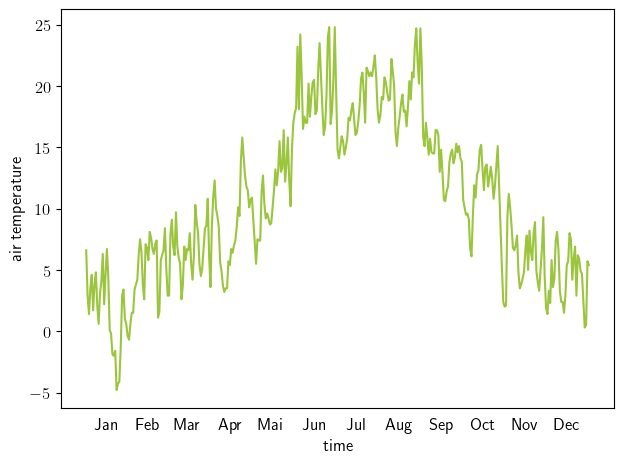

In [7]:
plt.plot(data.MESS_DATUM[data.year == 2019], data.TMK[data.year == 2019], color=colors[2])
plt.ylabel('air temperature')
plt.xlabel('time')
plt.xticks(pd.to_datetime(['2019-01-15', 
    '2019-02-15', 
    '2019-03-15', 
    '2019-04-15', 
    '2019-05-15', 
    '2019-06-15', 
    '2019-07-15', 
    '2019-08-15', 
    '2019-09-15', 
    '2019-10-15', 
    '2019-11-15',
    '2019-12-15',
    ]), ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tight_layout()
plt.savefig('plots/air_temp_2019.pdf')

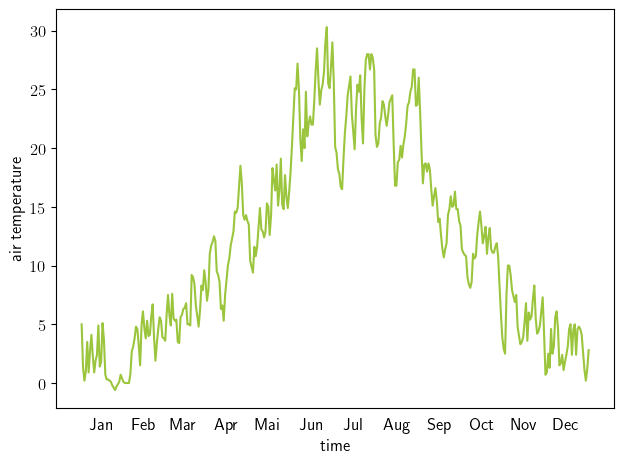

In [8]:
plt.plot(data.MESS_DATUM[data.year == 2019], data.V_TE005M[data.year == 2019], color=colors[2])
plt.ylabel('air temperature')
plt.xlabel('time')
plt.xticks(pd.to_datetime(['2019-01-15', 
    '2019-02-15', 
    '2019-03-15', 
    '2019-04-15', 
    '2019-05-15', 
    '2019-06-15', 
    '2019-07-15', 
    '2019-08-15', 
    '2019-09-15', 
    '2019-10-15', 
    '2019-11-15',
    '2019-12-15',
    ]), ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tight_layout()
plt.savefig('plots/ground_temp_2019.pdf')

## Average yearly ground and air temperature and first flowering date phenology of wood anemone.

Again, not necessary for the analysis, but quite nice to see.

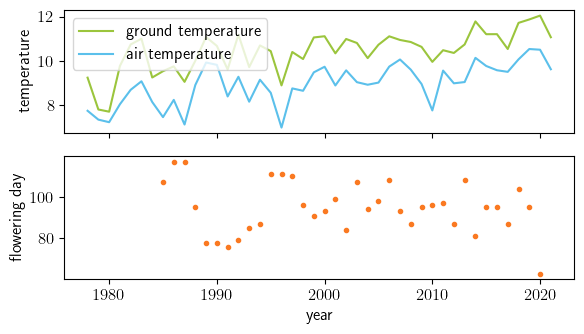

In [18]:
temp_years = data.groupby('year')[['V_TE005M', 'TMK']].mean().reset_index()

fig, axes = plt.subplots(2, 1, sharex=True)

fig.set_size_inches(6, 3.5)

ax = axes[0]

ax.plot(temp_years.year, temp_years.V_TE005M, color=colors[2], label='ground temperature')
ax.plot(temp_years.year, temp_years.TMK, color=colors[0], label='air temperature')

#ax.set_xlabel('year')
ax.set_ylabel('temperature')

ax.legend(loc='upper left')

ax = axes[1]

ax.plot(phen_data.Referenzjahr[phen_data.Referenzjahr > 1978], phen_data.Jultag[phen_data.Referenzjahr > 1978], '.', color=colors[4])
ax.set_xlabel('year')
ax.set_ylabel('flowering day')

fig.tight_layout()
fig.savefig('plots/temp_years_hgw.pdf')

## Air temperature vs. ground temperature daily

Daily ground temperature vs air temperature. Not used later, as we use the average monthly temperature, but one can see that when using daily values, the error would be much larger.  
The regression here uses only values where the air temperature is above 0, as their is a clear change in the relationship below 0.

                            OLS Regression Results                            
Dep. Variable:               V_TE005M   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 1.595e+05
Date:                Sun, 18 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:38:58   Log-Likelihood:                -31452.
No. Observations:               14256   AIC:                         6.291e+04
Df Residuals:                   14254   BIC:                         6.292e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1198      0.037    -30.198      0.0

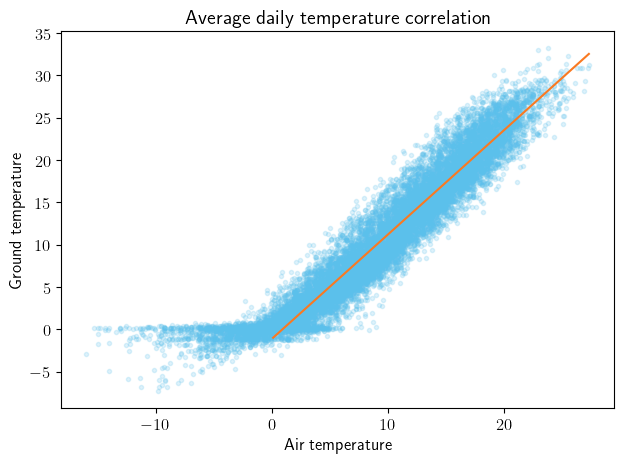

In [21]:
data_no_freeze = data[data.TMK > 0]

X = sm.add_constant(data_no_freeze['TMK'])
fit = sm.OLS(data_no_freeze['V_TE005M'], X).fit()
print(fit.summary())
print(f'std error: {np.sqrt(fit.scale)}')

x = np.array([np.min(data_no_freeze['TMK']), np.max(data_no_freeze['TMK'])])
y = fit.params['TMK'] * x + fit.params['const']

plt.plot(data['TMK'], data['V_TE005M'], '.', alpha=0.2, color=colors[0])
plt.plot(x, y, color=colors[4])

plt.xlabel('Air temperature')
plt.ylabel('Ground temperature')
plt.title('Average daily temperature correlation')
plt.tight_layout()
plt.savefig('plots/daily_temp_greifswald.svg')
plt.savefig('plots/daily_temp_greifswald.pdf')

## Air temperature vs. ground temperature monthly

The regression here uses only values where the air temperature is above 0, as their is a clear change in the relationship below 0.

The standard error from this is later used as an estimate of the measurement error of the actual regression.

                            OLS Regression Results                            
Dep. Variable:               V_TE005M   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 1.553e+04
Date:                Sun, 18 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:39:05   Log-Likelihood:                -803.34
No. Observations:                 483   AIC:                             1611.
Df Residuals:                     481   BIC:                             1619.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1487      0.116     -9.900      0.0

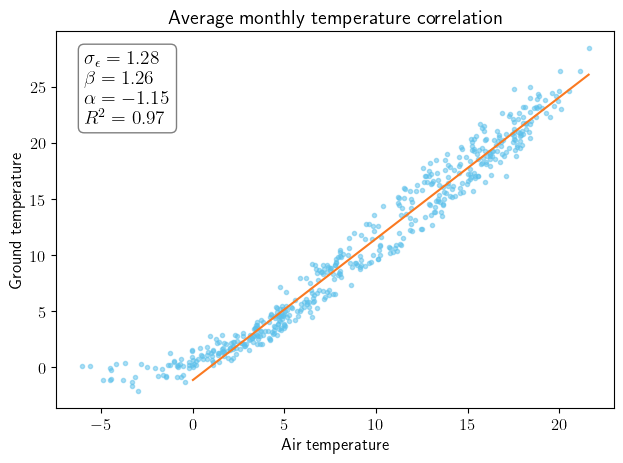

In [22]:
monthly_no_freeze = monthly[monthly.TMK > 0]

X = sm.add_constant(monthly_no_freeze.TMK)
fit = sm.OLS(monthly_no_freeze.V_TE005M, X).fit()
print(fit.summary())
print(f'std error: {np.sqrt(fit.scale)}')
sigma_eta_actual = np.sqrt(fit.scale)

x = np.array([np.min(monthly_no_freeze.TMK), np.max(monthly_no_freeze.TMK)])
y = x * fit.params['TMK'] + fit.params['const']

fig, ax = plt.subplots()

ax.plot(monthly.TMK, monthly.V_TE005M, '.', color=colors[0], alpha=0.5)
ax.plot(x, y, color=colors[4])

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, f'$\sigma_\epsilon = {sigma_eta_actual:.3}$\n$' + r'\beta' + f' = {fit.params["TMK"]:.3}$\n$' + r'\alpha' + f' = {fit.params["const"]:.3}$\n$R^2 = {fit.rsquared:.3}$', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel('Air temperature')
ax.set_ylabel('Ground temperature')
ax.set_title('Average monthly temperature correlation')
fig.tight_layout()
fig.savefig('plots/monthly_temp_greifswald.svg')
fig.savefig('plots/monthly_temp_greifswald.pdf')

## Regress ground temperature against flowering date

This is to show that ground temperature is actually a better predictor, most likely it is not as good as expected because the ground temperature was not taken exactly at the flowers.

                            OLS Regression Results                            
Dep. Variable:                 Jultag   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     36.03
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           8.54e-07
Time:                        10:39:24   Log-Likelihood:                -128.11
No. Observations:                  36   AIC:                             260.2
Df Residuals:                      34   BIC:                             263.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        115.8022      3.828     30.254      0.0

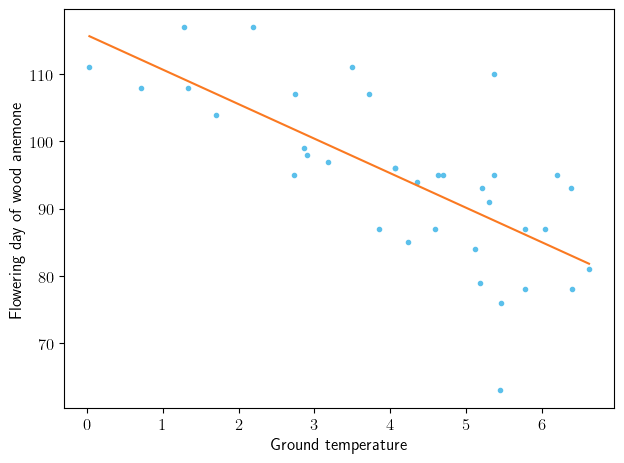

In [23]:
X = sm.add_constant(phen_temp.V_TE005M)
fit = sm.OLS(phen_temp.Jultag, X).fit()
print(fit.summary())
print(np.sqrt(fit.scale))

x = np.array([np.min(phen_temp.V_TE005M), np.max(phen_temp.V_TE005M)])
y = fit.params['V_TE005M'] * x + fit.params['const']

plt.plot(phen_temp.V_TE005M, phen_temp.Jultag, '.', color=colors[0])
plt.plot(x, y, color=colors[4])
plt.xlabel('Ground temperature')
plt.ylabel('Flowering day of wood anemone')
plt.tight_layout()
plt.savefig('plots/phen_ground_temp.svg')
plt.savefig('plots/phen_ground_temp.pdf')

## Regress air temperature against flowering date

This regression is assumed to be a "normal case" that people would do in general. It is obviously worse than using the ground temperature, but ground temperature is usually not as readily available.

                            OLS Regression Results                            
Dep. Variable:                 Jultag   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     34.66
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           1.21e-06
Time:                        10:41:08   Log-Likelihood:                -128.47
No. Observations:                  36   AIC:                             260.9
Df Residuals:                      34   BIC:                             264.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.0378      3.014     36.512      0.0

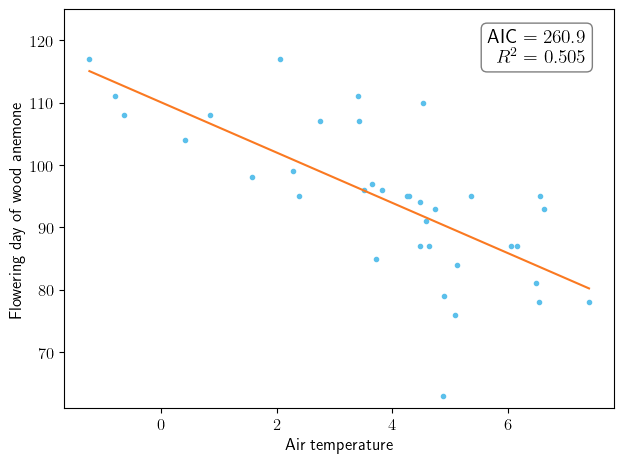

In [25]:
X = sm.add_constant(phen_temp.TMK)
fit = sm.OLS(phen_temp.Jultag, X).fit()
print(fit.summary())
print(np.sqrt(fit.scale))

x = np.array([np.min(phen_temp.TMK), np.max(phen_temp.TMK)])
y = fit.params['TMK'] * x + fit.params['const']

fig, ax = plt.subplots()

ax.set_ylim(61, 125)
ax.plot(phen_temp.TMK, phen_temp.Jultag, '.', color=colors[0])
ax.plot(x, y, color=colors[4])
ax.set_xlabel('Air temperature')
ax.set_ylabel('Flowering day of wood anemone')
fig.tight_layout()

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.95, 0.95, f'AIC $ = {fit.aic:.4}$\n' + f'$R^2 = {fit.rsquared:.3}$', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props)

fig.savefig('plots/phen_air_temp.svg')
fig.savefig('plots/phen_air_temp.pdf')

## Correct AIC for predictor error

We can now use our estimate of the predictor error to correct the AIC value. 

AIC difference: 26.968801002630244


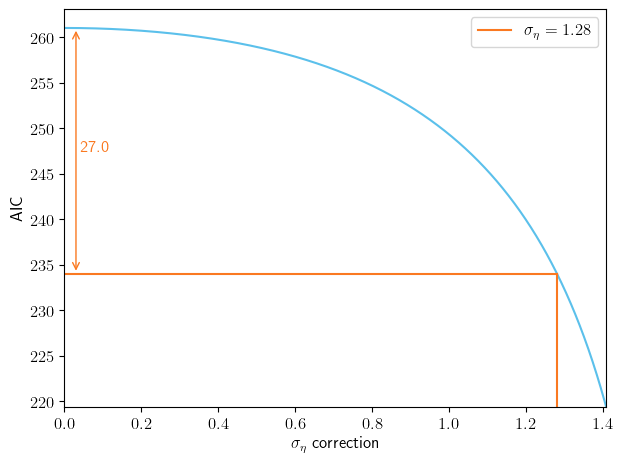

In [28]:
sample_size = len(phen_temp)
sigma_x = np.std(phen_temp.TMK)
beta_est = fit.params['TMK']
sigma_eps_est = np.sqrt(fit.scale)
sigma_etas = np.linspace(0, sigma_eta_actual * 1.1 , 1000)

aics = np.zeros(sigma_etas.shape)

for i, sigma_eta in enumerate(sigma_etas):
    aics[i] = correct_aic(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est, k=1)

c_aic = correct_aic(sample_size, beta_est, sigma_x, sigma_eta_actual, sigma_eps_est, k=1)

print(f'AIC difference: {aics[0] - c_aic}')

plt.plot(sigma_etas, aics, color=colors[0])
plt.plot([sigma_eta_actual, sigma_eta_actual], [np.min(aics), c_aic], color=colors[4], label=f'$\sigma_\eta = {sigma_eta_actual:.3}$')
plt.plot([sigma_etas[0], sigma_eta_actual], [c_aic, c_aic], color=colors[4])

plt.annotate('', [0.03, c_aic], [0.03, aics[0]], arrowprops={'arrowstyle':'<->', 'color': colors[4]})
plt.annotate(f'{aics[0] - c_aic:.3}', [0.04, c_aic + (aics[0] - c_aic) / 2], color=colors[4])

plt.ylim(bottom=aics[-1])
plt.xlim(sigma_etas[0], sigma_etas[-1])
plt.legend()
plt.xlabel('$\sigma_\eta$ correction')
plt.ylabel('AIC')
plt.tight_layout()
plt.savefig('plots/aic_correct_month.svg')
plt.savefig('plots/aic_correct_month.pdf')

                            OLS Regression Results                            
Dep. Variable:                 Jultag   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     34.66
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           1.21e-06
Time:                        10:42:19   Log-Likelihood:                -128.47
No. Observations:                  36   AIC:                             260.9
Df Residuals:                      34   BIC:                             264.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.0378      3.014     36.512      0.0

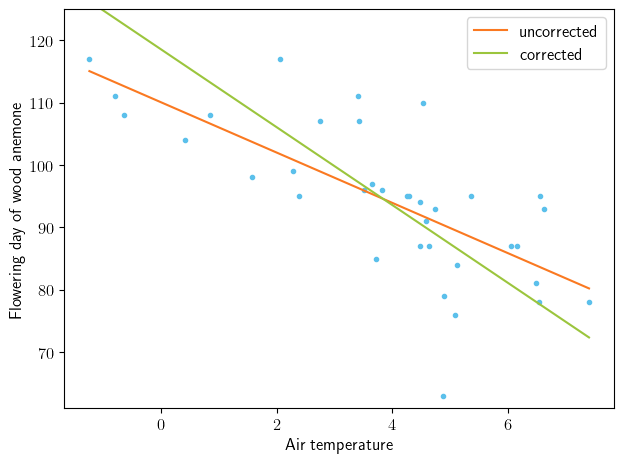

In [29]:
X = sm.add_constant(phen_temp.TMK)
fit = sm.OLS(phen_temp.Jultag, X).fit()
print(fit.summary())
print(np.sqrt(fit.scale))

x = np.array([np.min(phen_temp.TMK), np.max(phen_temp.TMK)])
y = fit.params['TMK'] * x + fit.params['const']

beta_c = correct_beta(fit.params['TMK'], sigma_x, sigma_eta_actual)
alpha_c = np.mean(phen_temp.Jultag) - beta_c * np.mean(phen_temp.TMK)
y_correct = beta_c * x + alpha_c

plt.ylim(61, 125)
plt.plot(phen_temp.TMK, phen_temp.Jultag, '.', color=colors[0])
plt.plot(x, y, color=colors[4], label='uncorrected')
plt.plot(x, y_correct, color=colors[2], label='corrected')
plt.legend()
plt.xlabel('Air temperature')
plt.ylabel('Flowering day of wood anemone')
plt.tight_layout()
plt.savefig('plots/phen_air_temp_corrected.pdf')

## All the plots in one

AIC difference: 26.968801002630244


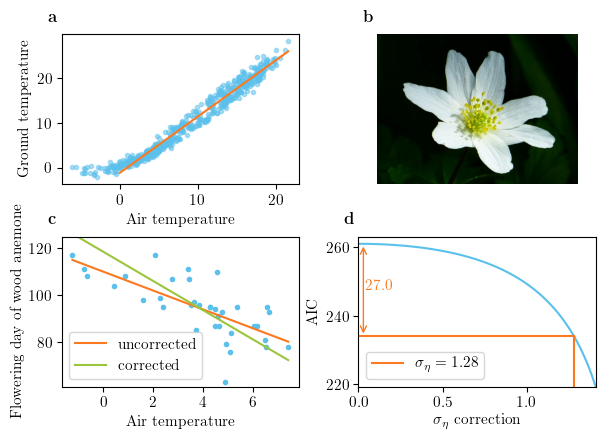

In [39]:
fig, axes = plt.subplot_mosaic([['a', 'b'], ['c', 'd']], 
                               gridspec_kw = dict(height_ratios=[1, 1], width_ratios=[1, 1], 
                                                  wspace=0.25, hspace=0.35, 
                                                  left=0.1,right=.99,top=.94,bottom=0.12))

fig.set_size_inches(6, 4.3)

for label, ax1 in axes.items():
    # label physical distance to the left and up:
    if label == 'legend':
        continue
    trans = mtransforms.ScaledTranslation(-10/72, 7/72, fig.dpi_scale_trans)
    ax1.text(0, 1.0, r'\textbf{' + label + '}', transform=ax1.transAxes + trans,
            fontsize=12, weight='bold', va='bottom')



## wood anemone picture

ax = axes['b']

## TODO: image of wood anemone

im = Image.open('plots/wood_anemone.jpg')
ax.imshow(im)

ax.set_axis_off()

## temp-temp correlation -> get sigma eta

ax = axes['a']

monthly_no_freeze = monthly[monthly.TMK > 0]

X = sm.add_constant(monthly_no_freeze.TMK)
fit = sm.OLS(monthly_no_freeze.V_TE005M, X).fit()
sigma_eta_actual = np.sqrt(fit.scale)

x = np.array([np.min(monthly_no_freeze.TMK), np.max(monthly_no_freeze.TMK)])
y = x * fit.params['TMK'] + fit.params['const']

ax.plot(monthly.TMK, monthly.V_TE005M, '.', color=colors[0], alpha=0.5)
ax.plot(x, y, color=colors[4])

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
#ax.text(0.05, 0.95, f'$\sigma_\epsilon = {sigma_eta_actual:.3}$\n$' + r'\beta' + f' = {fit.params["TMK"]:.3}$\n$' + r'\alpha' + f' = {fit.params["const"]:.3}$\n$R^2 = {fit.rsquared:.3}$', transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)

ax.set_xlabel('Air temperature')
ax.set_ylabel('Ground temperature')


## AIC correction

ax = axes['d']

X = sm.add_constant(phen_temp.TMK)
fit = sm.OLS(phen_temp.Jultag, X).fit()

sample_size = len(phen_temp)
sigma_x = np.sqrt(np.var(phen_temp.TMK) - sigma_eta_actual**2)
beta_est = fit.params['TMK']
sigma_eps_est = np.sqrt(fit.scale)
sigma_etas = np.linspace(0, sigma_eta_actual * 1.1 , 1000)

aics = np.zeros(sigma_etas.shape)

for i, sigma_eta in enumerate(sigma_etas):
    aics[i] = correct_aic(sample_size, beta_est, sigma_x, sigma_eta, sigma_eps_est, k=1)

c_aic = correct_aic(sample_size, beta_est, sigma_x, sigma_eta_actual, sigma_eps_est, k=1)

print(f'AIC difference: {aics[0] - c_aic}')

ax.plot(sigma_etas, aics, color=colors[0])
ax.plot([sigma_eta_actual, sigma_eta_actual], [np.min(aics), c_aic], color=colors[4], label=f'$\sigma_\eta = {sigma_eta_actual:.3}$')
ax.plot([sigma_etas[0], sigma_eta_actual], [c_aic, c_aic], color=colors[4])

ax.annotate('', [0.03, c_aic], [0.03, aics[0]], arrowprops={'arrowstyle':'<->', 'color': colors[4]})
ax.annotate(f'{aics[0] - c_aic:.3}', [0.04, c_aic + (aics[0] - c_aic) / 2], color=colors[4])

ax.set_ylim(bottom=aics[-1])
ax.set_xlim(sigma_etas[0], sigma_etas[-1])
ax.legend()
ax.set_xlabel('$\sigma_\eta$ correction')
ax.set_ylabel('AIC')

## air-temp-FFD correlation + corrected correlation

ax = axes['c']

x = np.array([np.min(phen_temp.TMK), np.max(phen_temp.TMK)])
y = fit.params['TMK'] * x + fit.params['const']

beta_c = correct_beta(fit.params['TMK'], sigma_x, sigma_eta_actual)
alpha_c = np.mean(phen_temp.Jultag) - beta_c * np.mean(phen_temp.TMK)
y_correct = beta_c * x + alpha_c

ax.set_ylim(61, 125)
ax.plot(phen_temp.TMK, phen_temp.Jultag, '.', color=colors[0])
ax.plot(x, y, color=colors[4], label='uncorrected')
ax.plot(x, y_correct, color=colors[2], label='corrected')
ax.legend()
ax.set_xlabel('Air temperature')
ax.set_ylabel('Flowering day of wood anemone')



fig.savefig('plots/all_together.pdf')